In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(28)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [14]:
client

Client Scheduler: tcp://10.148.0.147:50482 Dashboard: http://10.148.0.147:8787/status,Cluster Workers: 56 Cores: 224 Memory: 2800.00 GB


---


# 1. Drifter data files

## Raw dataset

In [6]:
ds= xr.open_dataset('/home1/datawork/xyu/Drifters/From_Elipot/driftertrajWMLE_1.01.nc')
ds

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


<xarray.Dataset>
Dimensions:  (TIME: 115238880)
Coordinates:
  * TIME     (TIME) datetime64[ns] 1990-03-11T11:00:00 1990-03-11T12:00:00 ...
Data variables:
    ID       (TIME) float64 ...
    LAT      (TIME) float64 ...
    LON      (TIME) float64 ...
    U        (TIME) float64 ...
    V        (TIME) float64 ...
    LAT_ERR  (TIME) float64 ...
    LON_ERR  (TIME) float64 ...
    U_ERR    (TIME) float64 ...
    V_ERR    (TIME) float64 ...
    GAP      (TIME) timedelta64[ns] ...
    RMSGAP   (TIME) timedelta64[ns] ...
    DROGUE   (TIME) float64 ...
Attributes:
    title:        Hourly Argos-tracked drifters location and velocity estimat...
    description:  This is version 1.01 of the dataset. See Elipot et al. 2016...
    note:         For all variables of dimension TIME, interruptions in the e...
    creator:      Shane Elipot, University of Miami, RSMAS
    timestamp:    16-Jan-2017 11:05:27

In [7]:
KE = ds.U**2 + ds.V**2
KE = np.real(KE).rename('KE')
KE.to_dataset()

<xarray.Dataset>
Dimensions:  (TIME: 115238880)
Coordinates:
  * TIME     (TIME) datetime64[ns] 1990-03-11T11:00:00 1990-03-11T12:00:00 ...
Data variables:
    KE       (TIME) float64 0.461 0.4606 0.4597 0.4586 0.4561 0.4508 0.4503 ...

In [8]:
ds = xr.merge([ds,KE])
ds

<xarray.Dataset>
Dimensions:  (TIME: 115238880)
Coordinates:
  * TIME     (TIME) datetime64[ns] 1990-03-11T11:00:00 1990-03-11T12:00:00 ...
Data variables:
    ID       (TIME) float64 ...
    LAT      (TIME) float64 ...
    LON      (TIME) float64 ...
    U        (TIME) float64 0.4847 0.4846 0.4844 0.4842 0.4835 0.4817 0.4811 ...
    V        (TIME) float64 0.4755 0.4751 0.4744 0.4734 0.4715 0.4677 0.4678 ...
    LAT_ERR  (TIME) float64 ...
    LON_ERR  (TIME) float64 ...
    U_ERR    (TIME) float64 ...
    V_ERR    (TIME) float64 ...
    GAP      (TIME) timedelta64[ns] ...
    RMSGAP   (TIME) timedelta64[ns] ...
    DROGUE   (TIME) float64 ...
    KE       (TIME) float64 0.461 0.4606 0.4597 0.4586 0.4561 0.4508 0.4503 ...

In [16]:
E_drifters_mean = ds.KE.groupby_bins(ds.LAT, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['TIME'])
E_drifters_mean_500m = E_drifters_mean.load()

In [19]:
E_drifters_std = ds.KE.groupby_bins(ds.LAT, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).std(dim=['TIME'])
E_drifters_std_500m = E_drifters_std.load()

Text(0.5,1,'Drifters')

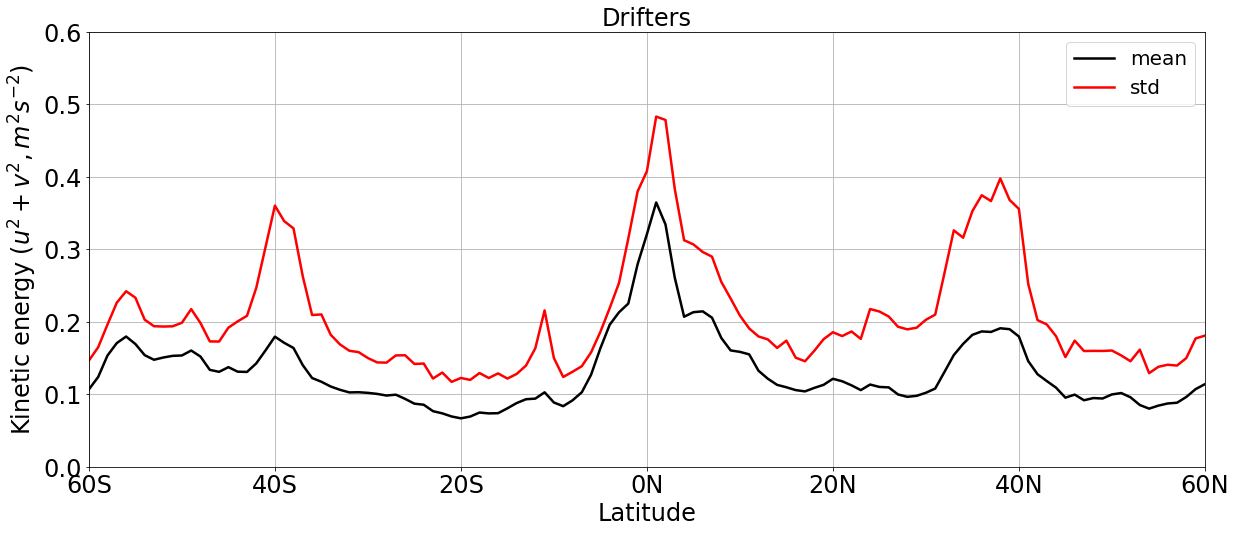

In [20]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['mean','std']

E_drifters_mean_500m.plot(color='black', label=labels[0], linewidth=2.5)
E_drifters_std_500m.plot(color='red', label=labels[1], linewidth=2.5)
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.6])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Drifters',fontsize=24)


Text(0.5,1,'Drifters (std)')

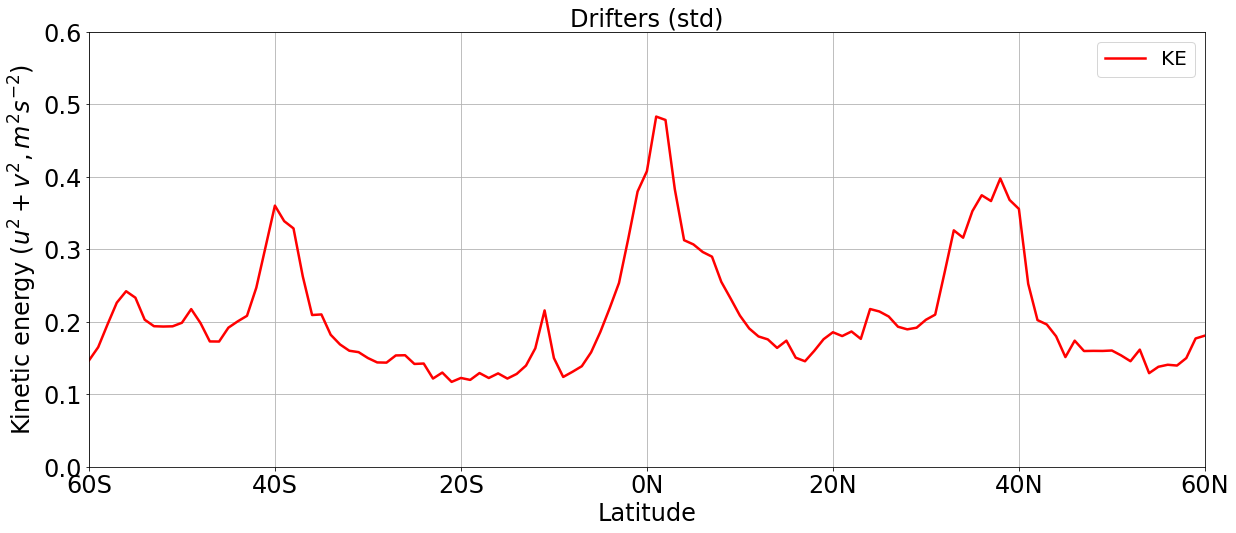

In [21]:
fig, ax = plt.subplots(figsize=(20,8))

E_drifters_std_500m.plot(color='red', linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.6])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters (std)',fontsize=24)

Text(0.5,1,'Drifters (mean)')

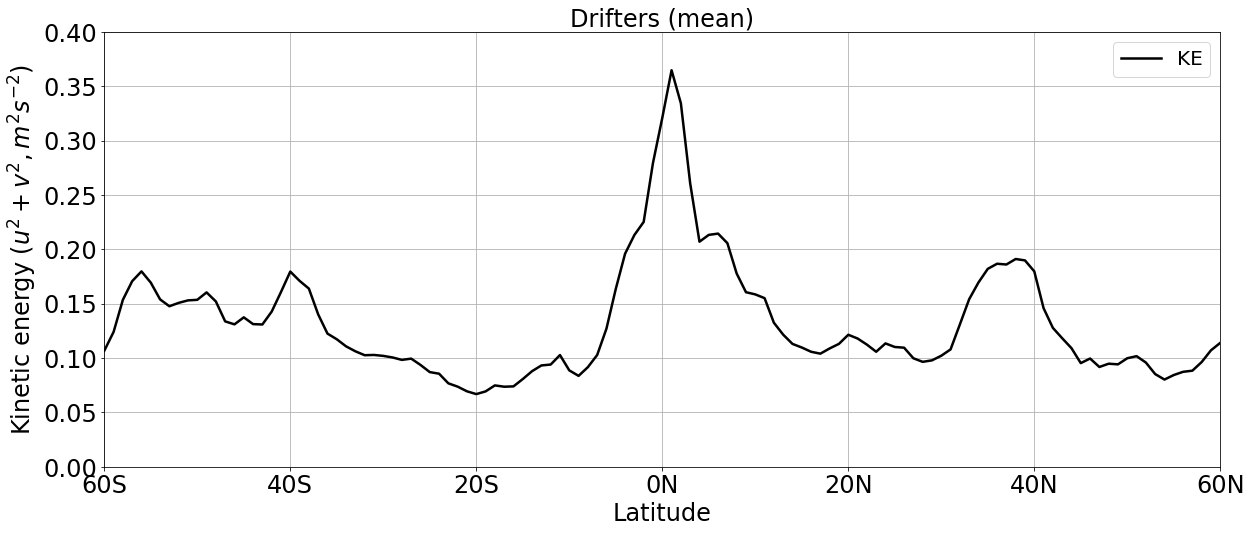

In [23]:
fig, ax = plt.subplots(figsize=(20,8))

E_drifters_mean_500m.plot(color='black', linewidth=2.5)
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters (mean)',fontsize=24)

## Processed dataset

In [7]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/'

drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processing.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     126303*1
# mlon2: mean longitude over 60 days,    126303*1

# qd: drogued drifters,                  126303*1
# qmed200: median water depth > 200 m,   126303*1
# qu: undrogued drifters,                126303*1

# uv2: (u, v),                           126303*1440

[('dpth2', <HDF5 dataset "dpth2": shape (126310, 1440), type "<f8">),
 ('dr2', <HDF5 dataset "dr2": shape (126310, 1440), type "<f8">),
 ('lat2', <HDF5 dataset "lat2": shape (126310, 1440), type "<f8">),
 ('lon2', <HDF5 dataset "lon2": shape (126310, 1440), type "<f8">),
 ('uv2', <HDF5 dataset "uv2": shape (126310, 1440), type "|V16">)]

In [9]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['lat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['blocks', 'time'])
lat = lat.mean(dim='time')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (blocks: 126310, time: 1440)>
array([[ 38.86296,  38.87079,  38.87931, ...,  39.11986,  39.11944,  39.1188 ],
       [ 39.53322,  39.52819,  39.52119, ...,  40.40588,  40.4187 ,  40.4242 ],
       [ 39.11828,  39.1172 ,  39.11632, ...,  39.40889,  39.40995,  39.41111],
       ...,
       [-61.13832, -61.14008, -61.14252, ..., -60.74699, -60.74471, -60.74403],
       [ 35.22614,  35.22895,  35.22965, ...,  31.3884 ,  31.3899 ,  31.39079],
       [ 30.01273,  30.02235,  30.0292 , ...,  25.5772 ,  25.57586,  25.57485]])
Dimensions without coordinates: blocks, time

In [30]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['dr2']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['blocks', 'time'])
qd = qd.mean(dim='time')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (blocks: 126310)>
array([0., 0., 0., ..., 1., 1., 1.])
Dimensions without coordinates: blocks

In [31]:
# turn drogued_information into xarray_DataArray
dpth2 = drifter_dataset['dpth2']
dpth2 = np.array(dpth2)
dpth2 = xr.DataArray(dpth2, dims=['blocks', 'time'])
dpth2 = dpth2.mean(dim='time')
dpth2 = np.real(dpth2).rename('dpth2')
dpth2

<xarray.DataArray 'dpth2' (blocks: 126310)>
array([-5527.829016, -5572.267612, -5518.365124, ..., -4307.954806,
       -3607.032922, -4717.820593])
Dimensions without coordinates: blocks

In [15]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((126310, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
u_drifters = uv[:,:,0] 
v_drifters = uv[:,:,1]

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'uv_drifters': (['blocks', 'time'], uv_drifters),
                 'u_drifters': (['blocks', 'time'], u_drifters),
                 'v_drifters': (['blocks', 'time'], v_drifters),},
                 coords={'blocks': (['blocks'], np.arange(126310)),
                         'time':(['time'], np.arange(1440)*3600),
                        'dpth2':(['blocks'], dpth2),
                        'lat':(['blocks'], lat),
                        'qd':(['blocks'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (blocks: 126310, time: 1440)
Coordinates:
  * blocks       (blocks) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    dpth2        (blocks) float64 -5.528e+03 -5.572e+03 -5.518e+03 ...
    lat          (blocks) float64 39.52 39.68 40.44 32.82 33.22 33.98 35.36 ...
    qd           (blocks) float64 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Data variables:
    uv_drifters  (blocks, time) complex128 (-0.2105+0.2479j) ...
    u_drifters   (blocks, time) float64 -0.2105 -0.1988 -0.1829 -0.1951 ...
    v_drifters   (blocks, time) float64 0.2479 0.2534 0.2546 0.1472 0.1497 ...

 data size: 5.8 GB


In [33]:
file_E = data_dir+'mit_spec/Drifter_all.zarr'
%time ds.to_zarr(file_E, mode='w')  

CPU times: user 8.19 s, sys: 1.25 s, total: 9.44 s
Wall time: 8.24 s


_________
# 2. Rotary spectra of Drifter uv

In [5]:
data_dir = '/home1/datawork/xyu/Drifters/'
ds = xr.open_zarr(data_dir+'mit_spec/Drifter_all.zarr').chunk({'time': 1440, 'blocks': 10000}) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (blocks: 126310, time: 1440)
Coordinates:
  * blocks       (blocks) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    dpth2        (blocks) float64 dask.array<shape=(126310,), chunksize=(10000,)>
    lat          (blocks) float64 dask.array<shape=(126310,), chunksize=(10000,)>
    qd           (blocks) float64 dask.array<shape=(126310,), chunksize=(10000,)>
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
Data variables:
    u_drifters   (blocks, time) float64 dask.array<shape=(126310, 1440), chunksize=(10000, 1440)>
    uv_drifters  (blocks, time) complex128 dask.array<shape=(126310, 1440), chunksize=(10000, 1440)>
    v_drifters   (blocks, time) float64 dask.array<shape=(126310, 1440), chunksize=(10000, 1440)>

 data size: 5.8 GB


In [35]:
KE_drifters = (ds.u_drifters**2 + ds.v_drifters**2)
KE_drifters 

<xarray.DataArray (blocks: 126310, time: 1440)>
dask.array<shape=(126310, 1440), dtype=float64, chunksize=(10000, 1440)>
Coordinates:
  * blocks   (blocks) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    dpth2    (blocks) float64 dask.array<shape=(126310,), chunksize=(10000,)>
    lat      (blocks) float64 dask.array<shape=(126310,), chunksize=(10000,)>
    qd       (blocks) float64 dask.array<shape=(126310,), chunksize=(10000,)>
  * time     (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...

In [57]:
KE_drifters_mean = KE_drifters.where(KE_drifters.dpth2<-500).mean(dim='time')
E_drifters_mean = KE_drifters_mean.groupby_bins(KE_drifters_mean.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['blocks'])
E_drifters_500m = E_drifters_mean.load()

In [58]:
KE_drifters_mean = KE_drifters.where(KE_drifters.dpth2<-1000).mean(dim='time')
E_drifters_mean = KE_drifters_mean.groupby_bins(KE_drifters_mean.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['blocks'])
E_drifters_1000m = E_drifters_mean.load()

No handles with labels found to put in legend.


Text(0.5,1,'Drifters')

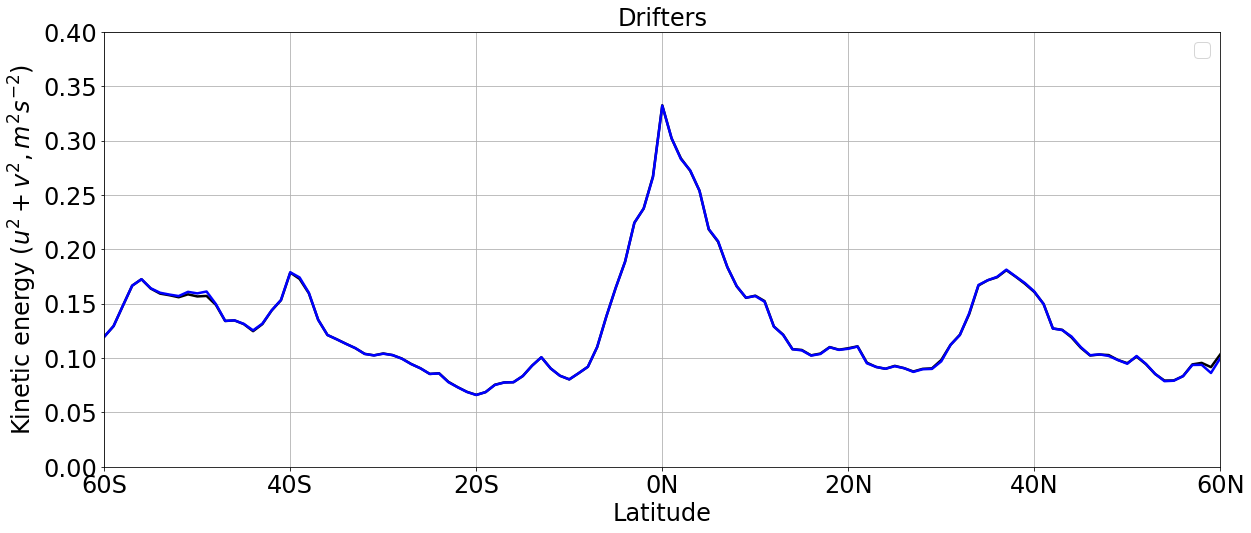

In [59]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_500m.plot(color='black', linewidth=2.5)
E_drifters_1000m.plot(color='blue', linewidth=2.5)


ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

In [54]:
KE_drifters_mean = KE_drifters.where(KE_drifters.dpth2<-500).mean(dim='time')
KE_drifters_mean

<xarray.DataArray (blocks: 126310)>
dask.array<shape=(126310,), dtype=float64, chunksize=(10000,)>
Coordinates:
  * blocks   (blocks) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    dpth2    (blocks) float64 dask.array<shape=(126310,), chunksize=(10000,)>
    lat      (blocks) float64 dask.array<shape=(126310,), chunksize=(10000,)>
    qd       (blocks) float64 dask.array<shape=(126310,), chunksize=(10000,)>

In [25]:
cluster.scheduler.close()

<Future finished result=None>